# **Setup And Data Loading**

In [96]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from dotenv import load_dotenv
from transformers import pipeline
from tqdm import tqdm

# 1. setup
sns.set_theme(style="whitegrid")
tqdm.pandas()

# Load Credentials
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, "..", ".."))
load_dotenv(os.path.join(project_root, '.env.cred'))

DB_CONFIG = {
    'host': os.getenv('DB_HOST'), 'port': os.getenv('DB_PORT', '3306'),
    'user': os.getenv('DB_USER'), 'password': os.getenv('DB_PASSWORD'),
    'database': os.getenv('DB_NAME')
}
connection_string = f"mysql+pymysql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"
engine = create_engine(connection_string)

def run_query(query, params=None):
    return pd.read_sql(query, engine, params=params)

# 2.load raw data
# We need raw surveys for NLP/Channels, and Events for Genres
sql_surveys = """
SELECT 
    pes.survey_id,
    pes.event_id,
    pes.event_title,

    COALESCE(
        pes.date,
        e.date,
        e_title.date
    ) AS survey_date,

    pes.source_of_hearing,
    pes.age_group,
    pes.annual_household_income,
    pes.overal_event_expression,
    pes.feeback_suggestion

FROM post_event_surveys pes
LEFT JOIN events e 
    ON pes.event_id = e.event_id

LEFT JOIN events e_title 
    ON REPLACE(LOWER(pes.event_title), ' ', '') 
     = REPLACE(LOWER(e_title.event_title), ' ', '');
"""
df_surveys = run_query(sql_surveys)

sql_events = "SELECT event_id, event_title FROM events;"
df_events = run_query(sql_events)

# 3. redo genre type
# We use the same NLP logic from Notebook 01
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
candidate_labels = ["Theatre Play", "Musical", "Music Concert", "Film Screening", "Comedy Show", "Fundraiser / Gala", "Workshop / Class"]

def categorize_with_nlp(title):
    try:
        return classifier(title, candidate_labels, multi_label=False)['labels'][0]
    except:
        return "General/Other"

df_events['genre'] = df_events['event_title'].progress_apply(categorize_with_nlp)

# Merge Genre onto Surveys
df_surveys = pd.merge(df_surveys, df_events[['event_id', 'genre']], on='event_id', how='left')

df_surveys.head()

'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 65727267-4b4b-487f-b9a9-e2997315a0b3)')' thrown while requesting HEAD https://huggingface.co/facebook/bart-large-mnli/resolve/main/config.json
Retrying in 1s [Retry 1/5].
Device set to use mps:0
100%|██████████| 206/206 [01:32<00:00,  2.23it/s]


,survey_id,event_id,event_title,survey_date,source_of_hearing,age_group,annual_household_income,overal_event_expression,feeback_suggestion,genre
0,1,68.0,VISHNIAC,2024-03-27,"Poster, Social Media (Facebook, Twitter, Insta...",56-65,"$200,001 or above",Although the volume was a little quiet for me ...,I always drink water at the shows and feel bad...,Musical
1,2,68.0,VISHNIAC,2024-03-27,Gesa Power House Theatre website (www.phtww.org),66+,"$50,001 - $100,000",Loved it!,Totally enjoyed the event.\nThank you for offe...,Musical
2,3,68.0,VISHNIAC,2024-03-27,Other,66+,"$50,001 - $100,000",Excellent film! Sound quality was a little mu...,I understand your preference for selling ticke...,Musical
3,4,68.0,VISHNIAC,2024-03-27,Walla Walla Union Bulletin,56-65,"$50,001 - $100,000","The documentary was fantastic, very interestin...","Nice staff and volunteers, thank you.",Musical
4,5,68.0,VISHNIAC,2024-03-27,Gesa Power House Theatre website (www.phtww.org),66+,"$50,001 - $100,000",very interesting film; no problems with showin...,None,Musical


# **Marketing Impact Analysis**

/var/folders/p6/7rqrp6w17vl0ny3w4x6480br0000gn/T/ipykernel_28492/3360126451.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_corr, x='Correlation', y='Channel', palette=colors)


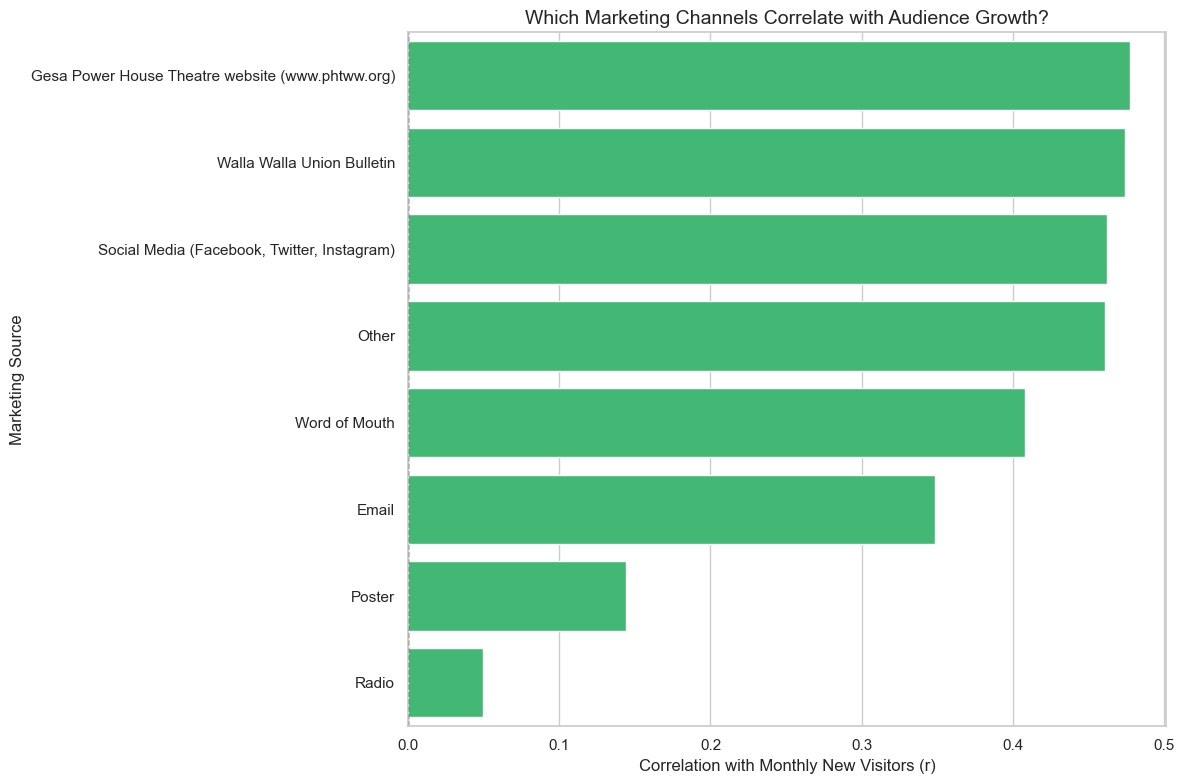

In [104]:
# 1. fetch attendance data
sql_attendance_growth = """
SELECT 
    DATE_FORMAT(month_year, '%%Y-%%m-01') as month_str,
    total_first_time_visitors
FROM attendance;
"""
df_growth = run_query(sql_attendance_growth)

# 2. process marketing channels
df_marketing = df_surveys[['survey_id', 'source_of_hearing', 'survey_date']].copy()
df_marketing['month_key'] = pd.to_datetime(df_marketing['survey_date']).dt.strftime('%Y-%m-01')

df_marketing['source_list'] = df_marketing['source_of_hearing'].astype(str).str.split(r',\s*(?![^(]*\))', regex=True)

# clean more
df_exploded = df_marketing.explode('source_list')
df_exploded['source_clean'] = df_exploded['source_list'].str.strip()
df_exploded = df_exploded[df_exploded['source_clean'].str.lower() != 'nan']

# 3. calculate monthly marketing channels
# How many times was each channel mentioned per month?
monthly_channels = pd.crosstab(df_exploded['month_key'], df_exploded['source_clean'])

# 4. merge channels with attendance
df_analysis = pd.merge(monthly_channels, df_growth, left_index=True, right_on='month_str', how='inner')

# 5. correlation
correlations = {}
for channel in monthly_channels.columns:
    if monthly_channels[channel].sum() > 5: 
        r = df_analysis[channel].corr(df_analysis['total_first_time_visitors'])
        correlations[channel] = r


# Convert to DataFrame for plotting
df_corr = pd.DataFrame(list(correlations.items()), columns=['Channel', 'Correlation'])
df_corr = df_corr.sort_values('Correlation', ascending=False)

# 6. visualization
plt.figure(figsize=(12, 8))

sns.barplot(data=df_corr, x='Correlation', y='Channel', palette=colors)
plt.title('Which Marketing Channels Correlate with Audience Growth?', fontsize=14)
plt.xlabel('Correlation with Monthly New Visitors (r)')
plt.ylabel('Marketing Source')

plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

# **demographic profile**

/var/folders/p6/7rqrp6w17vl0ny3w4x6480br0000gn/T/ipykernel_28492/1911512534.py:169: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_age, x='age_group', y='estimated_attendance', ax=axes[0], palette='viridis')
/var/folders/p6/7rqrp6w17vl0ny3w4x6480br0000gn/T/ipykernel_28492/1911512534.py:176: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_income, x='annual_household_income', y='estimated_attendance', ax=axes[1], palette='magma')


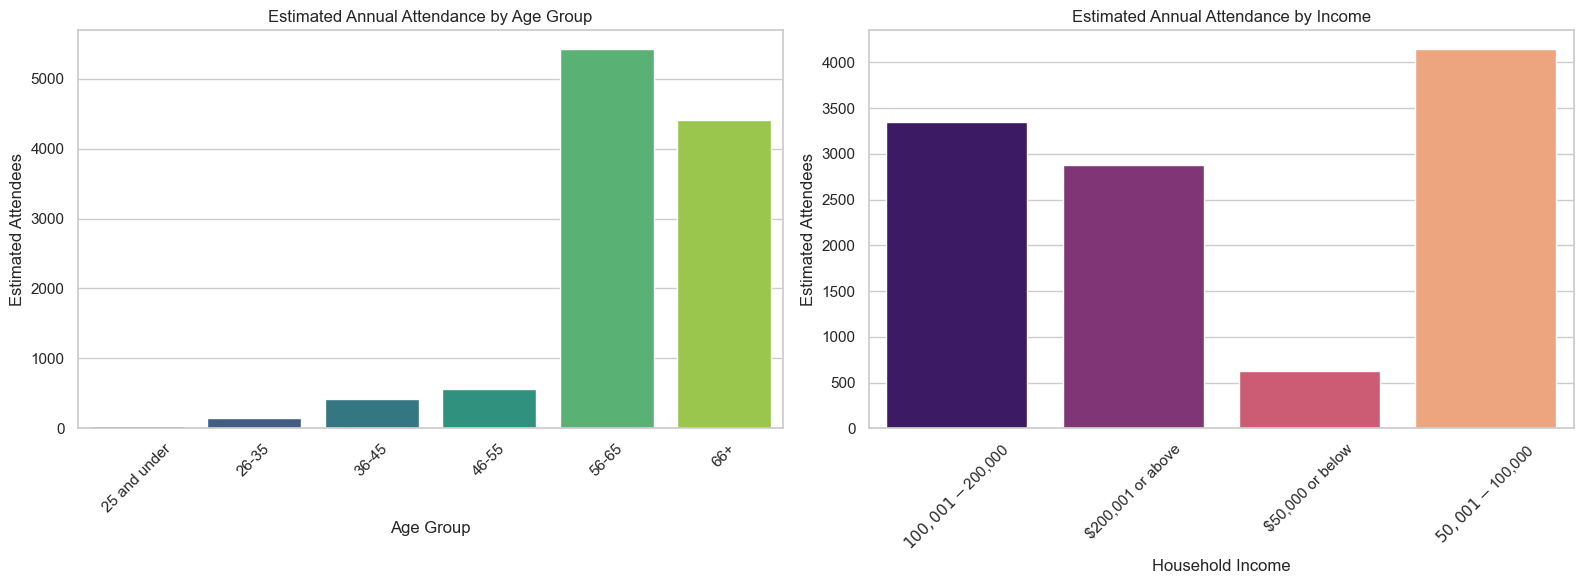

In [98]:
# age group estimation
sql_age = """
WITH survey_with_month AS (
    -- filter surveys for valid age entries
    SELECT 
        pes.survey_id,
        pes.age_group,
        DATE_FORMAT(pes.date, '%%Y-%%m-01') AS month_key
    FROM post_event_surveys pes
    WHERE pes.age_group IS NOT NULL
),

month_age_counts AS (
    -- aggregate survey counts by demographic
    SELECT
        month_key,
        age_group,
        COUNT(*) AS survey_count
    FROM survey_with_month
    GROUP BY
        month_key,
        age_group
),

month_survey_totals AS (
    -- calculate total surveys per month for weighting
    SELECT
        month_key,
        SUM(survey_count) AS total_surveys_in_month
    FROM month_age_counts
    GROUP BY month_key
),

month_attendance AS (
    -- fetch actual monthly attendance
    SELECT
        a.month_year AS month_key,
        a.total_attendance
    FROM attendance a
    WHERE a.total_attendance IS NOT NULL
),

estimated_age_attendance AS (
    -- calculate weighted estimate based on monthly ratios
    SELECT
        mac.age_group,
        SUM(
            mac.survey_count
            * ma.total_attendance
            / NULLIF(mst.total_surveys_in_month, 0)
        ) AS estimated_attendance
    FROM month_age_counts mac
    JOIN month_survey_totals mst
        ON mac.month_key = mst.month_key
    JOIN month_attendance ma
        ON mac.month_key = ma.month_key
    GROUP BY
        mac.age_group
),

total_attendance AS (
    -- calculate grand total for percentage share
    SELECT
        SUM(total_attendance) AS grand_total_attendance
    FROM attendance
    WHERE total_attendance IS NOT NULL
)

SELECT
    ea.age_group,
    ROUND(ea.estimated_attendance, 0) AS estimated_attendance,
    ROUND(
        ea.estimated_attendance / ta.grand_total_attendance,
        3
    ) AS share_of_total_attendance
FROM estimated_age_attendance ea
CROSS JOIN total_attendance ta
ORDER BY ea.age_group;
"""

df_age = run_query(sql_age)

# income group estimation
sql_income = """
WITH survey_with_month AS (
    -- filter surveys for valid income entries
    SELECT 
        pes.survey_id,
        pes.annual_household_income,
        DATE_FORMAT(pes.date, '%%Y-%%m-01') AS month_key
    FROM post_event_surveys pes
    WHERE pes.annual_household_income IS NOT NULL
),

month_income_counts AS (
    -- aggregate survey counts by income bracket
    SELECT
        month_key,
        annual_household_income,
        COUNT(*) AS survey_count
    FROM survey_with_month
    GROUP BY
        month_key,
        annual_household_income
),

month_survey_totals AS (
    -- calculate total surveys per month for weighting
    SELECT
        month_key,
        SUM(survey_count) AS total_surveys_in_month
    FROM month_income_counts
    GROUP BY month_key
),

month_attendance AS (
    -- fetch actual monthly attendance
    SELECT
        a.month_year AS month_key,
        a.total_attendance
    FROM attendance a
    WHERE a.total_attendance IS NOT NULL
),

estimated_income_attendance AS (
    -- calculate weighted estimate based on monthly ratios
    SELECT
        mic.annual_household_income,
        SUM(
            mic.survey_count
            * ma.total_attendance
            / NULLIF(mst.total_surveys_in_month, 0)
        ) AS estimated_attendance
    FROM month_income_counts mic
    JOIN month_survey_totals mst
        ON mic.month_key = mst.month_key
    JOIN month_attendance ma
        ON mic.month_key = ma.month_key
    GROUP BY
        mic.annual_household_income
),

total_attendance AS (
    -- calculate grand total for percentage share
    SELECT
        SUM(total_attendance) AS grand_total_attendance
    FROM attendance
    WHERE total_attendance IS NOT NULL
)

SELECT
    ea.annual_household_income,
    ROUND(ea.estimated_attendance, 0) AS estimated_attendance,
    ROUND(
        ea.estimated_attendance / ta.grand_total_attendance,
        3
    ) AS share_of_total_attendance
FROM estimated_income_attendance ea
CROSS JOIN total_attendance ta
ORDER BY ea.annual_household_income;
"""

df_income = run_query(sql_income)

# visualize demographics
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# age group plot
sns.barplot(data=df_age, x='age_group', y='estimated_attendance', ax=axes[0], palette='viridis')
axes[0].set_title('Estimated Annual Attendance by Age Group')
axes[0].set_xlabel('Age Group')
axes[0].set_ylabel('Estimated Attendees')
axes[0].tick_params(axis='x', rotation=45)

# income group plot
sns.barplot(data=df_income, x='annual_household_income', y='estimated_attendance', ax=axes[1], palette='magma')
axes[1].set_title('Estimated Annual Attendance by Income')
axes[1].set_xlabel('Household Income')
axes[1].set_ylabel('Estimated Attendees')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# **Mapping Preferences**

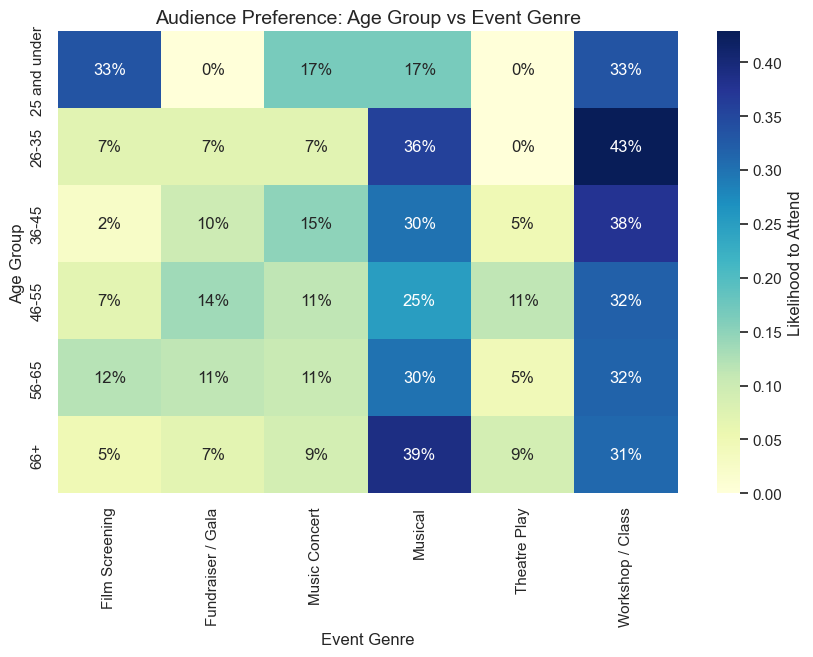

In [99]:
# pivot data to show age group preferences
preference_matrix = pd.crosstab(
    df_surveys['age_group'], 
    df_surveys['genre'], 
    normalize='index' 
)

# visualize with heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(preference_matrix, annot=True, fmt=".0%", cmap="YlGnBu", cbar_kws={'label': 'Likelihood to Attend'})
plt.title('Audience Preference: Age Group vs Event Genre', fontsize=14)
plt.ylabel('Age Group')
plt.xlabel('Event Genre')
plt.show()

## NLP to Extract Reoccuring Themes

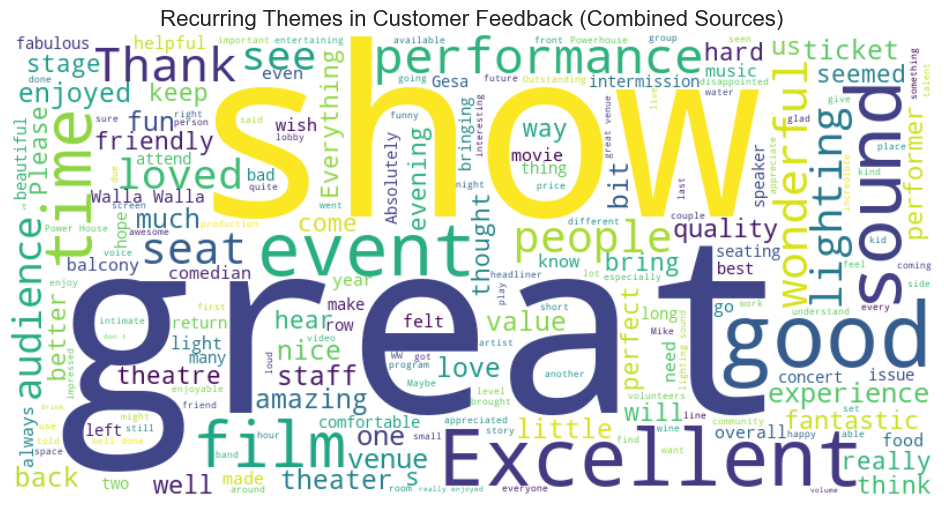

In [100]:
from wordcloud import WordCloud

# 1. merge and clean the data
df_surveys['text_A'] = df_surveys['overal_event_expression'].fillna('').replace('None', '', regex=True)
df_surveys['text_B'] = df_surveys['feeback_suggestion'].fillna('').replace('None', '', regex=True)

# Create a master column with all text
df_surveys['combined_text'] = df_surveys['text_A'] + " " + df_surveys['text_B']

# 2. generate word cloud
text_corpus = " ".join(df_surveys['combined_text'].astype(str))

wordcloud = WordCloud(width=800, height=400, background_color='white',  colormap='viridis', max_words=200, stopwords=None ).generate(text_corpus)

# 3. visalization
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Recurring Themes in Customer Feedback (Combined Sources)', fontsize=16)
plt.show()

## Score Sentiment per event and month

/var/folders/p6/7rqrp6w17vl0ny3w4x6480br0000gn/T/ipykernel_28492/28464055.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scored['month_str'] = pd.to_datetime(df_scored['survey_date']).dt.strftime('%Y-%m')
/var/folders/p6/7rqrp6w17vl0ny3w4x6480br0000gn/T/ipykernel_28492/28464055.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=event_sentiment.head(5), x='avg_score', y='event_title', ax=axes[0], palette='Greens_r')


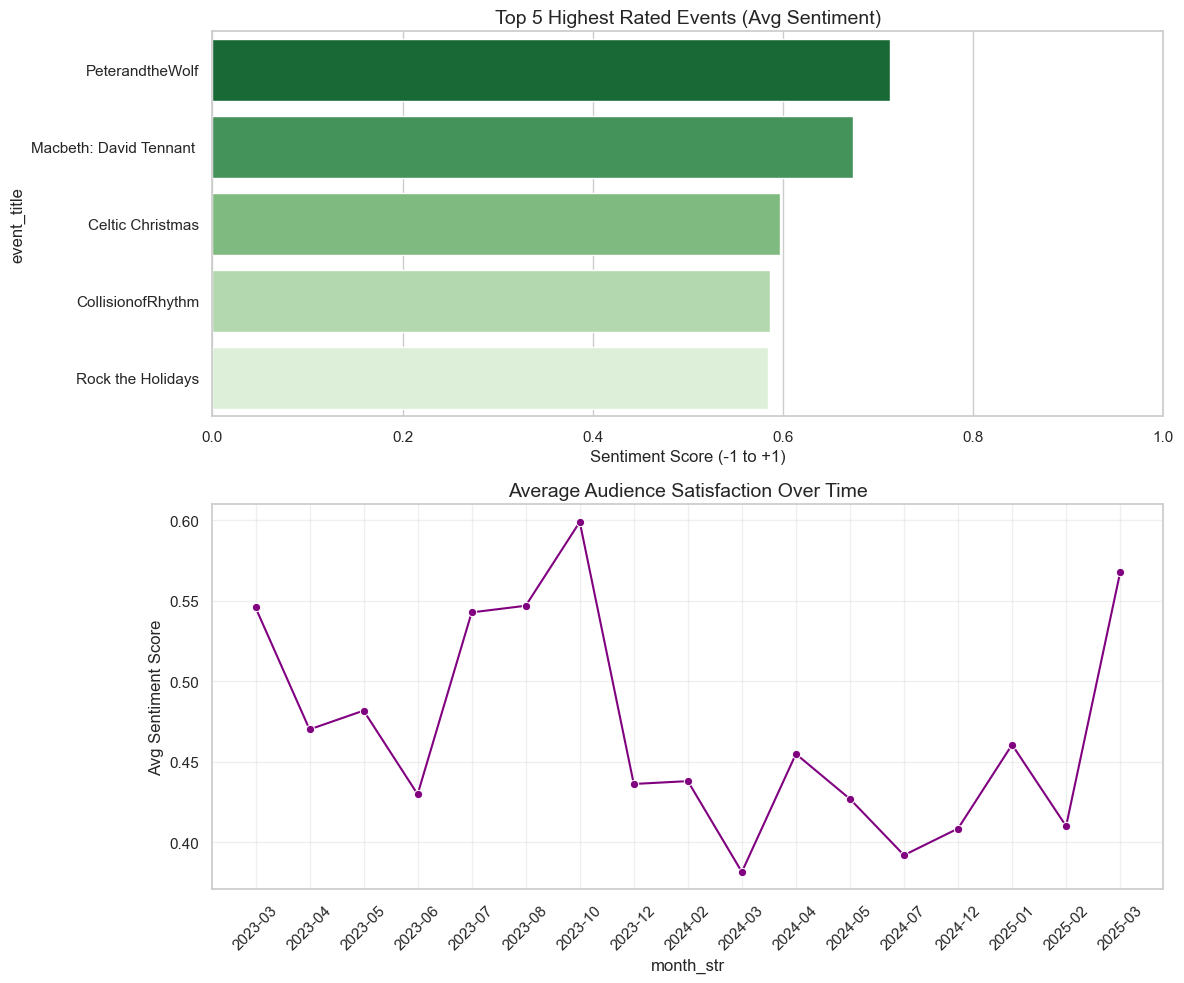

Top 3 Rated Events
                event_title  avg_score  review_count
40          PeterandtheWolf   0.712762             5
33  Macbeth: David Tennant    0.673326             4
7          Celtic Christmas   0.597147            49

Bottom 3 Rated Events
         event_title  avg_score  review_count
20     HolidayShorts   0.210977             9
46              SJFF   0.118681             6
27  Kira Soltanovich   0.005726            26


In [101]:

from textblob import TextBlob

# 1. score each response
def calculate_sentiment(text):
    if pd.isna(text) or str(text).strip() == "":
        return None 
    return TextBlob(str(text)).sentiment.polarity

df_surveys['sentiment_score'] = df_surveys['combined_text'].apply(calculate_sentiment)
df_scored = df_surveys.dropna(subset=['sentiment_score'])

# 2. group by events
event_sentiment = df_scored.groupby('event_title').agg(
    avg_score=('sentiment_score', 'mean'),
    review_count=('sentiment_score', 'count')
).reset_index()

# Filter for events with enough reviews to be statistically relevant (e.g., > 3 reviews)
event_sentiment = event_sentiment[event_sentiment['review_count'] > 3].sort_values('avg_score', ascending=False)

# 3. group by month (To track trends over time)
df_scored['month_str'] = pd.to_datetime(df_scored['survey_date']).dt.strftime('%Y-%m')
monthly_sentiment = df_scored.groupby('month_str')['sentiment_score'].mean().reset_index()

# 4. visalization
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot A: Top 5 Highest Rated Events
sns.barplot(data=event_sentiment.head(5), x='avg_score', y='event_title', ax=axes[0], palette='Greens_r')
axes[0].set_title('Top 5 Highest Rated Events (Avg Sentiment)', fontsize=14)
axes[0].set_xlabel('Sentiment Score (-1 to +1)')
axes[0].set_xlim(0, 1.0) # Sentiment is usually positive, so we focus on 0-1

# Plot B: Monthly Sentiment Trend
sns.lineplot(data=monthly_sentiment, x='month_str', y='sentiment_score', ax=axes[1], marker='o', color='purple')
axes[1].set_title('Average Audience Satisfaction Over Time', fontsize=14)
axes[1].set_ylabel('Avg Sentiment Score')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Top 3 Rated Events")
print(event_sentiment[['event_title', 'avg_score', 'review_count']].head(3))
print("\nBottom 3 Rated Events")
print(event_sentiment[['event_title', 'avg_score', 'review_count']].tail(3))

## Correlation between Satisfaction and attendance

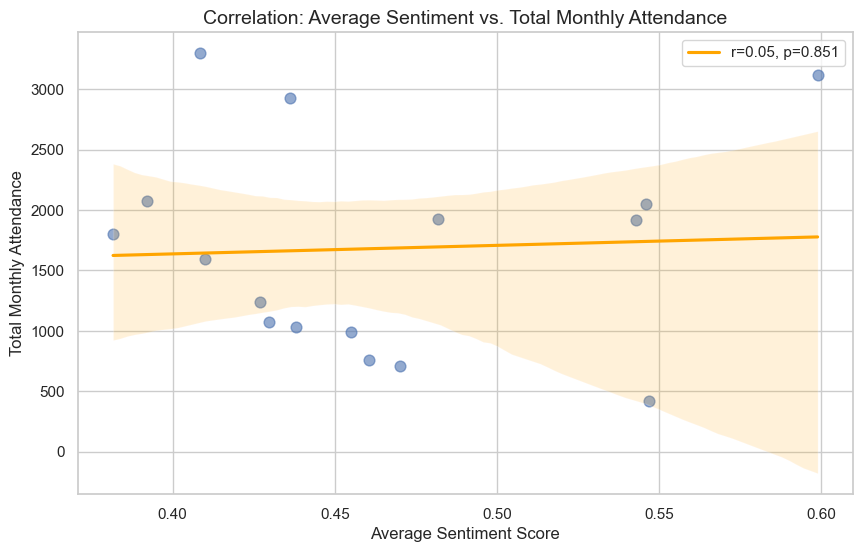

Correlation Coefficient (r): 0.05117053103514699
P-Value: 0.8507192022337033 (Not Significant)


In [102]:
from scipy import stats

# 1. Aggregate Sentiment by Month
df_surveys['month_str'] = pd.to_datetime(df_surveys['survey_date']).dt.strftime('%Y-%m-01')
monthly_sentiment = df_surveys.groupby('month_str')['sentiment_score'].mean().reset_index()

# 2. Fetch Total Monthly Attendance
sql_total_att = """
SELECT 
    DATE_FORMAT(month_year, '%%Y-%%m-01') as month_str,
    total_attendance
FROM attendance;
"""
df_attendance_totals = run_query(sql_total_att)

# 3. Merge Datasets
df_correlation = pd.merge(monthly_sentiment, df_attendance_totals, on='month_str', how='inner')

# 4. Statistical Test (Pearson Correlation)
r_val, p_val = stats.pearsonr(df_correlation['sentiment_score'], df_correlation['total_attendance'])
significance = "Significant" if p_val < 0.05 else "Not Significant"

# 5. Visualization
plt.figure(figsize=(10, 6))
sns.regplot(data=df_correlation, x='sentiment_score', y='total_attendance', scatter_kws={'alpha': 0.6, 's': 60},  line_kws={'color': 'orange', 'label': f'r={r_val:.2f}, p={p_val:.3f}'})

plt.title('Correlation: Average Sentiment vs. Total Monthly Attendance', fontsize=14)
plt.xlabel('Average Sentiment Score')
plt.ylabel('Total Monthly Attendance')
plt.legend()
plt.show()

print(f"Correlation Coefficient (r): {r_val}")
print(f"P-Value: {p_val} ({significance})")

In [117]:
output_dir = os.path.join("..", "output_csv")
os.makedirs(output_dir, exist_ok=True)

assert 'df_correlation' in locals(), "df_correlation does not exist"

df_correlation.to_csv(os.path.join(output_dir, "02_sentiment_impact.csv"),index=False)
print("Saved 02_sentiment_impact.csv")

assert 'df_surveys' in locals(), "df_surveys does not exist"

df_surveys.to_csv(os.path.join(output_dir, "02_raw_feedback.csv"),index=False)
print("Saved 02_raw_feedback.csv")

monthly_channels.reset_index(inplace = True)
monthly_channels.drop(columns= '', inplace=True)

assert 'monthly_channels' in locals(), "monthly_channels does not exist"

monthly_channels.to_csv(os.path.join(output_dir, "02_channels_counts.csv"),index=False)
print("Saved 02_channels_counts.csv")


Saved 02_sentiment_impact.csv
Saved 02_raw_feedback.csv
Saved 02_channels_counts.csv
